# Model Analysis

In this notebook we want to see for some selected model, what caseuse the low performance. 
By analysing the model's performance we want to have an intuition behing what causes the model to fail.

* First we do a confusion matrix of the entire validation set
* Look at the error rate for each samples and visualize the samples with high error rate
    * Check for corrupt images (image quality)
    * Since we are working with FIVES are they peculiar to a particular diseases? i.e how many samples of each diseases categories have high error rate.
    * Does it have to deal with the connecting vessels. 

In [1]:

from operator import add

from tqdm import tqdm
from dataset import get_data

from models import *
from metrics import *
from utils import read_image, process_image
import random
import cv2
import numpy as np
import torch
from models import *
from glob import glob
import matplotlib.pyplot as plt
from dataset import *
import pandas as pd
import seaborn as sns

/Users/jeremiahfadugba/opt/anaconda3/envs/retina/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
configs = {"model": "Unet",
           "data": "fives",
           "loss_fn": "clDice",
           "size": (224, 224),
           "augments": False,
           "data_path": 'datasets/',
           "result_path": 'results',
           "device": "cuda",
           "learning_rate": 0.001,
           "batch_size": 16,
           "epochs": 40,
           "num_workers": 2,
           }

In [3]:
#Data 
_, _, test_x, test_y = get_data(configs)


### Selecting the MANet Model with the clDice loss function

In [4]:

model_name = "MANet"
loss_fn = "cldice"
model_constructor = MANet

predictor_name = f"{configs['result_path']}/{model_name}/{configs['data']}/No_Augmentation_{loss_fn}"
model = model_constructor().to(device)
model.load_state_dict(torch.load(predictor_name, map_location=device))

images_scores = {}

for i, (x, y) in tqdm(enumerate(zip(test_x, test_y)), total=len(test_x)):
    """ Extract the name """
    name = x.split("/")[-1].split(".")[0]
    """ read and process image """
    image, mask = read_image(x, y)
    x, y = process_image(image, mask)

    with torch.no_grad():

        """ Prediction and Calculating FPS """
        pred_y = model.predict(x)
        # pred_y = torch.sigmoid(pred_y)
        score = calculate_metrics(y, pred_y)

        images_scores[name] = score


 12%|█▏        | 24/200 [00:11<01:42,  1.72it/s]/Users/jeremiahfadugba/opt/anaconda3/envs/retina/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
100%|██████████| 200/200 [03:19<00:00,  1.00it/s]


In [5]:
score_column = ['jaccard_score', 'f1-score', 'Recall',
                'precision_score', 'accuracy_score', 'roc_auc_score']

manet_cldice_df = pd.DataFrame.from_dict(images_scores, orient='index', columns=score_column)
manet_cldice_df.index.rename('Image_ID', inplace=True)
manet_cldice_df = manet_cldice_df.reset_index()

In [6]:
manet_cldice_df['Diagnosis'] = manet_cldice_df.Image_ID.apply(lambda x: x.split('_')[-1])
manet_cldice_df['Number'] = manet_cldice_df.Image_ID.apply(lambda x: x.split('_')[0]).astype(int)

manet_cldice_df


,Image_ID,jaccard_score,f1-score,Recall,precision_score,accuracy_score,roc_auc_score,Diagnosis,Number
0,100_D,0.628001,0.771500,0.664573,0.919431,0.972517,0.830101,D,100
1,101_G,0.417582,0.589147,0.439053,0.895171,0.978874,0.718608,G,101
2,102_G,0.525129,0.688636,0.582616,0.841825,0.974390,0.788511,G,102
3,103_G,0.336524,0.503581,0.341045,0.962105,0.946130,0.669937,G,103
4,104_G,0.492576,0.660034,0.528169,0.879653,0.964585,0.761569,G,104
...,...,...,...,...,...,...,...,...,...
195,96_D,0.511083,0.676446,0.529765,0.935454,0.961316,0.763372,D,96
196,97_D,0.515038,0.679901,0.521054,0.978072,0.964007,0.760065,D,97
197,98_D,0.741280,0.851419,0.829842,0.874149,0.977679,0.909933,D,98
198,99_D,0.544249,0.704872,0.570670,0.921601,0.962333,0.783258,D,99


In [7]:
manet_cldice_df.groupby(['Diagnosis']).mean()


,jaccard_score,f1-score,Recall,precision_score,accuracy_score,roc_auc_score,Number
Diagnosis,,,,,,,
A,0.600472,0.743299,0.650436,0.895183,0.968451,0.821724,25.5
D,0.544771,0.694484,0.584481,0.901307,0.969470,0.789847,75.5
G,0.504135,0.645901,0.539125,0.877357,0.973950,0.767411,125.5
N,0.631719,0.772108,0.702677,0.862306,0.965544,0.846055,175.5


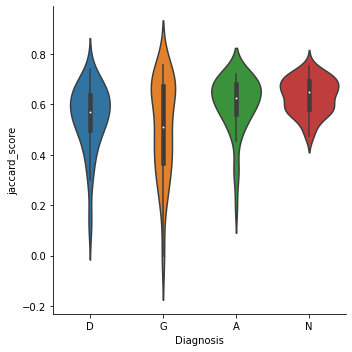

In [8]:
sns.catplot(data=manet_cldice_df, x="Diagnosis", y="jaccard_score", kind="violin")


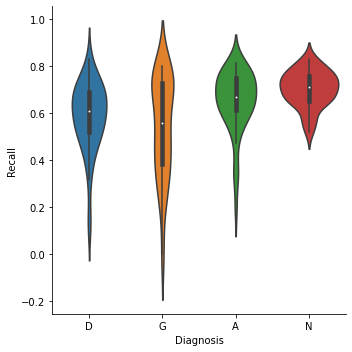

In [9]:
sns.catplot(data=manet_cldice_df, x="Diagnosis", y="Recall", kind="violin")


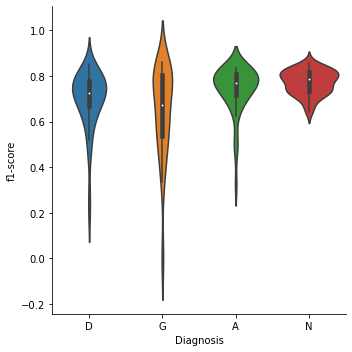

In [10]:
sns.catplot(data=manet_cldice_df, x="Diagnosis", y="f1-score", kind="violin")


In [11]:
# The next thing I want to do is to use the quality assessment data given to
# check whether the quality of the images per diagnosis is what gives the poor performance.

val_data_qual = pd.read_excel('datasets/FIVES/Quality Assessment.xlsx', sheet_name='Test')


In [12]:
jooined_df = manet_cldice_df.join(val_data_qual.set_index('Number'), on='Number')
jooined_df

,Image_ID,jaccard_score,f1-score,Recall,precision_score,accuracy_score,roc_auc_score,Diagnosis,Number,Disease,IC,Blur,LC
0,100_D,0.628001,0.771500,0.664573,0.919431,0.972517,0.830101,D,100,D,1,1,1
1,101_G,0.417582,0.589147,0.439053,0.895171,0.978874,0.718608,G,101,G,0,0,1
2,102_G,0.525129,0.688636,0.582616,0.841825,0.974390,0.788511,G,102,G,0,0,0
3,103_G,0.336524,0.503581,0.341045,0.962105,0.946130,0.669937,G,103,G,1,0,1
4,104_G,0.492576,0.660034,0.528169,0.879653,0.964585,0.761569,G,104,G,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,96_D,0.511083,0.676446,0.529765,0.935454,0.961316,0.763372,D,96,D,1,1,1
196,97_D,0.515038,0.679901,0.521054,0.978072,0.964007,0.760065,D,97,D,1,1,1
197,98_D,0.741280,0.851419,0.829842,0.874149,0.977679,0.909933,D,98,D,1,1,1
198,99_D,0.544249,0.704872,0.570670,0.921601,0.962333,0.783258,D,99,D,1,1,1


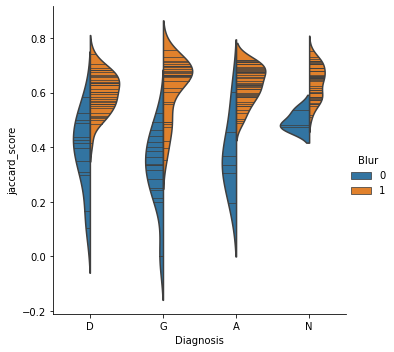

In [13]:
sns.catplot(data=jooined_df, x="Diagnosis", y="jaccard_score", hue='Blur', kind="violin", 
            inner="stick", split=True)

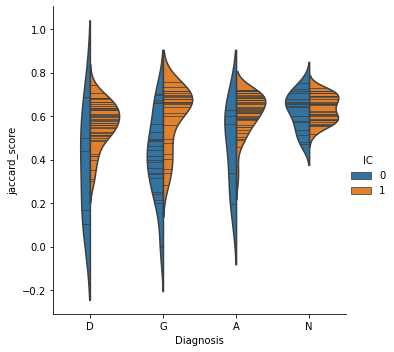

In [14]:
sns.catplot(data=jooined_df, x="Diagnosis", y="jaccard_score", hue='IC', kind="violin", 
            inner="stick", split=True)

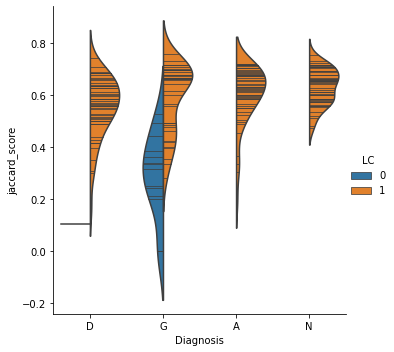

In [15]:
sns.catplot(data=jooined_df, x="Diagnosis", y="jaccard_score", hue='LC', kind="violin", 
            inner="stick", split=True)

<AxesSubplot:xlabel='Diagnosis', ylabel='jaccard_score'>

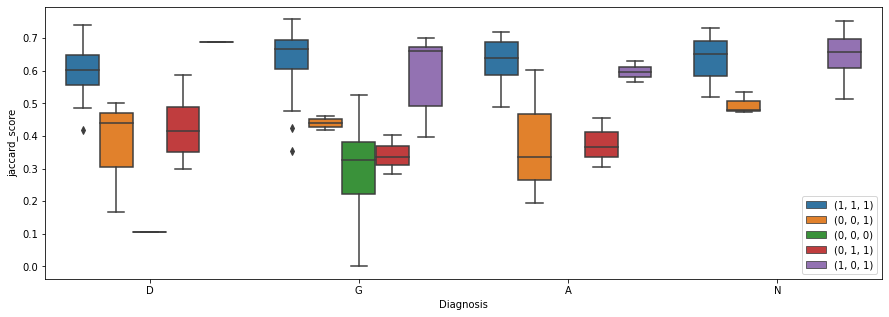

In [17]:
plt.figure(figsize=(15,5))
sns.boxplot(data=jooined_df, x="Diagnosis", y="jaccard_score",
                hue=jooined_df[['Blur', 'IC', 'LC']].apply(tuple, axis=1),
            )

<AxesSubplot:xlabel='Diagnosis', ylabel='jaccard_score'>

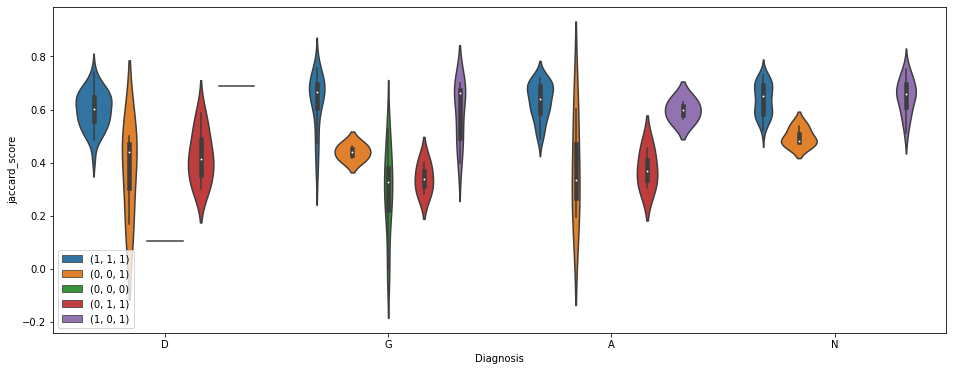

In [18]:
plt.figure(figsize=(16,6))
sns.violinplot(data=jooined_df, x="Diagnosis", y="jaccard_score",
                hue=jooined_df[['Blur', 'IC', 'LC']].apply(tuple, axis=1),
                scale_hue=True,
            )


In [20]:
# High performaing images
high_perf_images = manet_cldice_df[manet_cldice_df['jaccard_score'] > 0.7]
# select Images with scores less than 0.7

low_perf_images = manet_cldice_df[manet_cldice_df['jaccard_score'] < 0.5]
